In [1]:
dataset_name = "exchange-3_cpc_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '1H', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")


# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="1H", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-07-14 10:15:01",
                      "2011-07-20 10:15:01",
                      "2011-08-13 10:15:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:15:01
End date:  2011-09-07 14:15:01
Missing time stamps: 
 DatetimeIndex(['2011-07-07 03:15:01', '2011-07-07 04:15:01',
               '2011-07-08 03:15:01', '2011-07-08 04:15:01',
               '2011-07-08 05:15:01', '2011-07-08 07:15:01',
               '2011-07-08 08:15:01', '2011-07-08 11:15:01',
               '2011-07-08 12:15:01', '2011-07-08 13:15:01',
               ...
               '2011-09-01 14:15:01', '2011-09-01 15:15:01',
               '2011-09-01 16:15:01', '2011-09-01 17:15:01',
               '2011-09-04 18:15:01', '2011-09-04 20:15:01',
               '2011-09-05 14:15:01', '2011-09-05 16:15:01',
               '2011-09-06 00:15:01', '2011-09-06 13:15:01'],
              dtype='datetime64[ns]', length=109, freq=None)
Fill Missing Time Steps with Interpolation
Length:  1647
Time step size:  1H
Start Date:  2011-07-01 00:15:01
End Date:  2011-09-07 14:15:01
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [322, 466, 1042]


# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

100%|██████████| 1647/1647 [00:00<00:00, 17693.09it/s]

Initial Mean 0.1678398153513733
Initial StdDev 0.08488834374875458



100%|██████████| 1647/1647 [00:00<00:00, 17312.81it/s]

eta:  0.5
lambda:  0.99
MSE:  0.004491109897346973
Initial Mean 0.1678398153513733
Initial StdDev 0.08488834374875458



100%|██████████| 1647/1647 [00:00<00:00, 13637.47it/s]

eta:  0.5
lambda:  0.999
MSE:  0.0050892758583803415
Initial Mean 0.1678398153513733
Initial StdDev 0.08488834374875458



100%|██████████| 1647/1647 [00:00<00:00, 14576.34it/s]

eta:  0.5
lambda:  0.9999
MSE:  0.005253457936344025
Initial Mean 0.1678398153513733
Initial StdDev 0.08488834374875458



100%|██████████| 1647/1647 [00:00<00:00, 16887.54it/s]

eta:  1
lambda:  0.99
MSE:  0.004538527057249815
Initial Mean 0.1678398153513733
Initial StdDev 0.08488834374875458



100%|██████████| 1647/1647 [00:00<00:00, 12817.69it/s]

eta:  1
lambda:  0.999
MSE:  0.004828038399503745
Initial Mean 0.1678398153513733
Initial StdDev 0.08488834374875458


eta:  1
lambda:  0.9999
MSE:  0.004937909672303108

best params:  eta 0.5 lambda 0.99


100%|██████████| 1647/1647 [00:00<00:00, 11687.55it/s]

Initial Mean 0.1678398153513733
Initial StdDev 0.08488834374875458


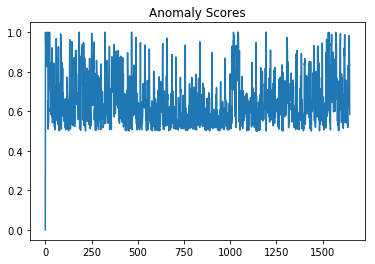

Time:  0.4833214282989502


['anomaly_scores/GLM/exchange-3_cpc_results']

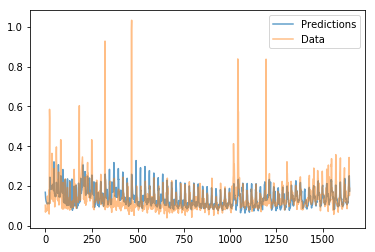

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=.5,
                     lambda_=.99,
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)


# Anomalous

In [6]:
# only need one window size

# save_path = "anomaly_scores/anomalous/" + dataset_name
# output_dict = ad.anomalous(ts_length=100,
#                            upper=(.2/100) * ad.get_length(),
#                            plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -557.8342
 ARIMA(1,0,0) with non-zero mean : -664.6779
 ARIMA(0,0,1) with non-zero mean : -659.5101
 ARIMA(0,0,0) with zero mean     : -557.9704
 ARIMA(2,0,0) with non-zero mean : -670.1725
 ARIMA(3,0,0) with non-zero mean : -668.2054
 ARIMA(2,0,1) with non-zero mean : -669.2125
 ARIMA(1,0,1) with non-zero mean : -672.4821
 ARIMA(1,0,2) with non-zero mean : -669.9256
 ARIMA(0,0,2) with non-zero mean : -668.4132
 ARIMA(1,0,1) with zero mean     : -673.9628
 ARIMA(0,0,1) with zero mean     : -659.0936
 ARIMA(1,0,0) with zero mean     : -666.2799
 ARIMA(2,0,1) with zero mean     : -670.5572
 ARIMA(1,0,2) with zero mean     : -671.3408
 ARIMA(0,0,2) with zero mean     : -669.6769
 ARIMA(2,0,0) with zero mean     : -671.7082
 ARIMA(2,0,2) with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with zero mean     :

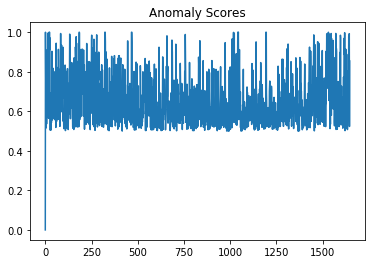

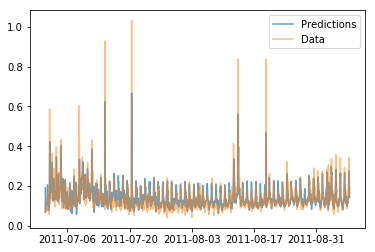

Time:  19.989680290222168


['anomaly_scores/SARIMA_auto/exchange-3_cpc_results']

In [7]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [8]:
# optimization step

step_sizes = [100, 200, 300, 400, 500]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005038875449981498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004161005904828483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0037367495257673


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034699542848819743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0033426957355166685


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00488367116753963


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004023087478702804


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003576348557162399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033665711634701593


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033072035698766726


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005022257598599956


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041712400425477515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003708488297100999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034305177633847037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003301091318189883


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0048798179556416976


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004003405773148095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035538679682819824


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364676893953818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.003292536754066335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0050166858284072585


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004135367980544857


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003741877826007131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034457083992271197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321146636183978


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004829206758218958


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0040134264491896235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035211549331039213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364375967228896


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032930207888975088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005044736595629421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041664399707679045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0036926180612685414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034837888110109305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00331711605046917


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004862730455350627


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004017919923269397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035955857315128166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033638394005213743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032843574704404456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005035291288543333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041637964840785455


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003810531889709155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.003403548131963962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321807351492845


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00485385923500971


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004018482686831045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003592712322995667


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033498617177697525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033014141629237356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005038875449981498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004161005904828483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0037367495257673


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034699542848819743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0033426957355166685


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00488367116753963


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004023087478702804


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003576348557162399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033665711634701593


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033072035698766726


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005022257598599956


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041712400425477515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003708488297100999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034305177633847037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003301091318189883


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0048798179556416976


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004003405773148095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035538679682819824


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364676893953818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.003292536754066335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0050166858284072585


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004135367980544857


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003741877826007131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034457083992271197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321146636183978


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004829206758218958


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0040134264491896235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035211549331039213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364375967228896


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032930207888975088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005044736595629421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041664399707679045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0036926180612685414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034837888110109305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00331711605046917


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004862730455350627


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004017919923269397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035955857315128166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033638394005213743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032843574704404456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005035291288543333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041637964840785455


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003810531889709155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.003403548131963962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321807351492845


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00485385923500971


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004018482686831045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003592712322995667


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033498617177697525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033014141629237356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005038875449981498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004161005904828483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0037367495257673


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034699542848819743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0033426957355166685


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00488367116753963


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004023087478702804


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003576348557162399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033665711634701593


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033072035698766726


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005022257598599956


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041712400425477515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003708488297100999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034305177633847037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003301091318189883


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0048798179556416976


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004003405773148095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035538679682819824


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364676893953818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.003292536754066335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0050166858284072585


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004135367980544857


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003741877826007131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034457083992271197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321146636183978


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004829206758218958


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0040134264491896235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035211549331039213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364375967228896


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032930207888975088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005044736595629421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041664399707679045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0036926180612685414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034837888110109305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00331711605046917


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004862730455350627


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004017919923269397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035955857315128166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033638394005213743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032843574704404456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005035291288543333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041637964840785455


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003810531889709155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.003403548131963962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321807351492845


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00485385923500971


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004018482686831045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003592712322995667


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033498617177697525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  300
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033014141629237356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005038875449981498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004161005904828483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0037367495257673


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034699542848819743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0033426957355166685


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00488367116753963


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004023087478702804


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003576348557162399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033665711634701593


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033072035698766726


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005022257598599956


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041712400425477515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003708488297100999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034305177633847037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003301091318189883


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0048798179556416976


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004003405773148095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035538679682819824


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364676893953818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.003292536754066335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0050166858284072585


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004135367980544857


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003741877826007131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034457083992271197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321146636183978


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004829206758218958


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0040134264491896235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035211549331039213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364375967228896


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032930207888975088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005044736595629421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041664399707679045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0036926180612685414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034837888110109305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00331711605046917


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004862730455350627


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004017919923269397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035955857315128166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033638394005213743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032843574704404456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005035291288543333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041637964840785455


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003810531889709155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.003403548131963962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321807351492845


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00485385923500971


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004018482686831045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003592712322995667


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033498617177697525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  400
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033014141629237356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005038875449981498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004161005904828483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0037367495257673


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034699542848819743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0033426957355166685


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00488367116753963


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004023087478702804


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003576348557162399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033665711634701593


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033072035698766726


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005022257598599956


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041712400425477515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003708488297100999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034305177633847037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003301091318189883


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0048798179556416976


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004003405773148095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035538679682819824


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364676893953818


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.003292536754066335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0050166858284072585


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.004135367980544857


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003741877826007131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034457083992271197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321146636183978


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004829206758218958


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0040134264491896235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035211549331039213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.003364375967228896


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032930207888975088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005044736595629421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041664399707679045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0036926180612685414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0034837888110109305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.00331711605046917


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.004862730455350627


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004017919923269397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0035955857315128166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033638394005213743


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0032843574704404456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.005035291288543333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0041637964840785455


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.003810531889709155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.003403548131963962


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.003321807351492845


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.00485385923500971


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.004018482686831045


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.003592712322995667


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0033498617177697525
Step Size:  500
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0033014141629237356

best params:  Step Size 100 Seasonality Prior Scale 15 Seasonality Mode multiplicative Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


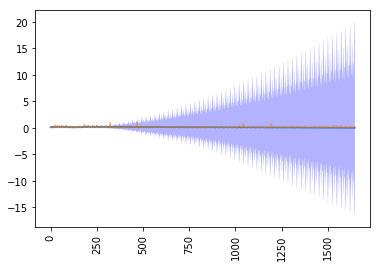

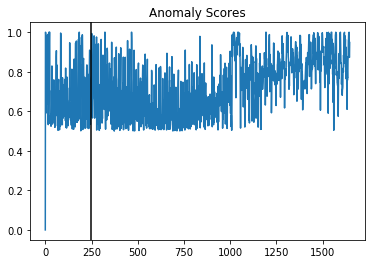

Time:  9.15152096748352


['anomaly_scores/Prophet/exchange-3_cpc_results']

In [9]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=15,
                                  seasonality_mode="multiplicative",
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [10]:
# only need one window size

# save_path = "anomaly_scores/Twitter/" + dataset_name
# output_dict = ad.twitterad(period=24,max_anoms=((.2/100) * ad.get_length())/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# HTM

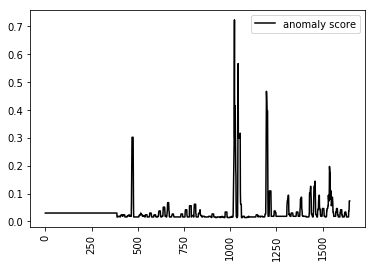

Time:  16.38


['anomaly_scores/HTM/exchange-3_cpc_results']

In [11]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "16.38")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "16.38"}
joblib.dump(output_dict, save_path)

# STL Resid

In [12]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15133390602835894
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1514744193642744
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15128786179057105
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15133390602835894
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.151262348493232
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15130697278145386
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
ou

R stlplus completed: 247 no missing True
STL Resid Sum:  0.18350308132645463
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.5038200865170362
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.5042086586314626
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.5036616493322444
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.5038200865170362
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.5035858527263538
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.5037

R stlplus completed: 247 no missing True
STL Resid Sum:  0.09520588458876941
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09520740963592474
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.4056972298432905
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.40599703259236586
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.40558170486981815
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.4056972298432905
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.4055230

R stlplus completed: 247 no missing True
STL Resid Sum:  4.5564168724496186e-05
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.325565182576432e-05
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.211472359456512e-05
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.28446900709472156
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.28469286719600306
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.28439165597969807
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  

R stlplus completed: 247 no missing True
STL Resid Sum:  0.28751004463453994
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.28756829145359497
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2874901032226937
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.28752894198010404
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10412470814123893
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10257592473829294
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10373284925466777
swindo

R stlplus completed: 247 no missing True
STL Resid Sum:  0.1176859599758031
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11808259966988995
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1179557389630632
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2774853690377492
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2755168451043932
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.27733856059375606
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2774853690377492
swindow:  5
sdegree:  0
twindo

R stlplus completed: 247 no missing True
STL Resid Sum:  0.05460527502784821
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.05609283587210167
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1899972161824861
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.19415247099252703
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.18794746676779187
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1899972161824861
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.18710381034095291
swindow:  5
sdegree:  1
twindow

R stlplus completed: 247 no missing True
STL Resid Sum:  2.5165990776479816e-06
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.041441491903193364
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.03951383220529874
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.042242061027028203
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.041441491903193364
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.04207868915186388
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.042162637968951686
swindow:  5
sdegree:  

R stlplus completed: 247 no missing True
STL Resid Sum:  0.12620507185023494
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12619740617817915
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12600263424954963
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12620507185023494
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12597126727119823
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12606674882447014
swindow:  7
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12170286362158562
swindow:  7
sdegree:  0
twind

R stlplus completed: 247 no missing True
STL Resid Sum:  0.35980532169027174
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.3596438514871781
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.35985254604084027
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.35975229549168214
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.3433543572886861
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.34029201318172514
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.34403211828225855
swindow:  7
sdegree:  0
t

R stlplus completed: 247 no missing True
STL Resid Sum:  0.270646356732148
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.26753224945658627
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2692492459001991
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2629185406565096
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.26882840413059145
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2609967768949192
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2629185406565096
swindow:  7
sdegree:  1
twindow:  9

R stlplus completed: 247 no missing True
STL Resid Sum:  0.1357254264672154
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.13766799517422645
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.13562224276737492
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1407849925281717
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1330409196501797
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.13562224276737492
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1319702192679463
swindow:  7
sdegree:  2
twindow: 

R stlplus completed: 247 no missing True
STL Resid Sum:  0.13257119625855862
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12888233387151904
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.126768704282253
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1301184758156427
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12888233387151904
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1303895981706471
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12974721943318931
swindow:  9
sdegree:  0
twindow: 

R stlplus completed: 247 no missing True
STL Resid Sum:  0.3706125650899587
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.37621291575673027
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.3749316618188258
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.37640281085902827
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.3758725251300754
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.23847144901013517
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2351961508335847
swindow:  9
sdegree:  0
twi

R stlplus completed: 247 no missing True
STL Resid Sum:  0.29177896229123135
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.29349378460505465
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.29113552722850683
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2924023961828636
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14724731484689732
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15296903593307346
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14583182565142266
swindow:  9
sdegree:  1
twindo

R stlplus completed: 247 no missing True
STL Resid Sum:  0.17090600332674155
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.16727527215308097
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.16919073599360404
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06526392436799099
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.07241500614540673
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06339513830575465
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06526392436799099
swindow:  9
sdegree:  2
twind

R stlplus completed: 247 no missing True
STL Resid Sum:  0.13646984598644327
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1360922705225796
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.210174527678869e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.120383962479632e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.0222149789115636e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.210174527678869e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.035261900036768e-05
swindow:  11


R stlplus completed: 247 no missing True
STL Resid Sum:  0.40174293323711235
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2506832076558429
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.24724549686933178
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2515530156690701
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2506832076558429
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.25163360187390005
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2513720115247796
swindow:  11
sdegree:

R stlplus completed: 247 no missing True
STL Resid Sum:  0.15208772931933084
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1565039749757703
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15099956975006307
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15208772931933084
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15056837967175915
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15140114884813116
swindow:  11
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.3739444722199409
swindow:  11
sdegree:  1

R stlplus completed: 247 no missing True
STL Resid Sum:  0.07868615039951594
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06776342274787438
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06975347115191032
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0669607694329892
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06852530636539328
swindow:  11
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.25957447641743153
swindow:  11
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.26624444416558135
swindow:  11
sdegree:  2

In [13]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=5, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

1647
R stlplus completed: 1647 no missing True
Time:  0.8259785175323486


['anomaly_scores/stl/exchange-3_cpc_results']

# windowed gaussian

In [14]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  0.007354503420004219
Step size:  200
MSE:  0.007354503420004219
Step size:  300
MSE:  0.007354503420004219
Step size:  400
MSE:  0.007354503420004219
Step size:  500
MSE:  0.007354503420004219

best step size:  100


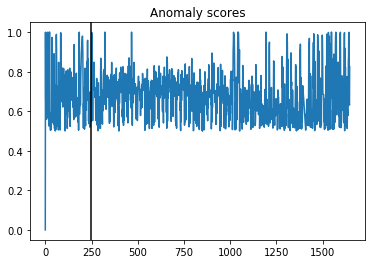

Time:  0.11223506927490234


['anomaly_scores/windowed_gaussian/exchange-3_cpc_results']

In [15]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

In [16]:
# only need one window size

# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)